![CDS 411 logo](../../img/cds-411-logo.png)

# Cellular automata I: Heat diffusion

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML

rc("animation", html="html5")

np.random.seed(1189773503)

## Background: Heat Diffusion

We will be building a cellular automata simulation of the diffusion of heat within a bar. Unlike a system dynamics model, this simulation will allow us to observe the heat flow at different positions within the bar. In effect, we will be able to simulate what the temperature of the bar will be not only at a given time, but at a given position in the bar.

The general idea of what we want to do is to to scale down **Newton's law of heating and cooling**. This states that the rate of change of the temperature with respect to time of an object is proportional to the difference between the temperature of the object and temperature of its surroundings. In the context of cellular automata, a cell's *surroundings* is defined by its surrounding neighbors in a grid.

![Two-dimensional heat transfer schematic](../../img/two-dimensional-heat-transfer.jpg)

There's different ways to define a cell's surroundings, or neighborhood. For our purposes, we will use the so-called **Moore neighborhood**, which consists of a cell's NW, N, NE, W, E, SW, S, and SE neighbors:

<table>
<tbody align="center">
  <tr>
    <td>NW</td>
    <td>N</td>
    <td>NE</td>
  </tr>
  <tr>
    <td>W</td>
    <td>site</td>
    <td>E</td>
  </tr>
  <tr>
    <td>SW</td>
    <td>S</td>
    <td>SE</td>
  </tr>
</tbody>
</table>

Having decided upon this, the simulation will require us to apply the diffusion formula to every site for each time step will be as follows:

$$
\dfrac{T_{m,n}^{i+1}-T_{m,n}^{i}}{\tau}=\sum_{m',n'}^{\text{neighborhood}}\left(T_{m',n'}^{i}-T_{m,n}^{i}\right)+\dfrac{\dot{e}_{m,n}^{i}l^{2}}{k}
$$

where $\tau=\dfrac{\alpha}{l^2}\Delta{}t$ is the so-called dimensionless mesh Fourier number, $\alpha=\dfrac{k}{\rho c}$ is the thermal diffusivity, $k$ is the material's thermal conductivity, $\rho$ is the material's density, and $c$ is the material's specific heat. $\dot{e}_{node}^i$ is the *rate of heat generation* within the cell and $l$ is the cell's length, $l=\Delta{}x=\Delta{}y$. Note that the term *rate of heat generation* corresponds to the rate at which other forms of energy are converted into thermal energy. This may include things like chemical reactions, heat energy from biological processes, and electrical current.

By rewriting the formula slightly, the connection of this expression with the finite difference equation becomes clear:

$$
T_{m,n}^{i+1}=T_{m,n}^{i}+\tau\left[\sum_{m',n'}^{\text{neighborhood}}\left(T_{m',n'}^{i}-T_{m,n}^{i}\right)+\dfrac{\dot{e}_{m,n}^{i}l^{2}}{k}\right]
$$

Applying the Moore neighborhood to our finite difference equation and assuming that $\dot{e}_{m,n}^{i}=0$ for all cells and for the entire simulation, the expression reduces to:

$$
T_{m,n}^{i+1}=\left(1-8\tau\right)T_{m,n}^{i}+\tau\sum_{m',n'}^{\text{Moore}}T_{m',n'}^{i}
$$

If we explicitly write out all the terms for the summation over the Moore neighborhood, we get:

$$
T_{m,n}^{i+1}=\left(1-8\tau\right)T_{m,n}^{i}+\tau\left(T_{m+1,n}+T_{m,n+1}+T_{m-1,n}+T_{m,n-1}+T_{m+1,n+1}+T_{m-1,n+1}+T_{m+1,n-1}+T_{m-1,n-1}\right)
$$

### Stability criterion

For the simulation to be stable, the following inequality must be satisfied: 

$$
\tau=\dfrac{\alpha\Delta{}t}{l^2}\leq\frac{1}{\text{number of neighbors}}
$$

## Building up our cellular automata simulation

In [2]:
def apply_hot_cold(bar, hot_sites, cold_sites, hot, cold):
    """Apply hot and cold temperatures to listed sites.
    
    Parameters
    ----------
    bar : np.array
        A grid of temperatures
        
    hot_sites : list
        A list of coordinates inside the `bar` grid that have temperature
        `hot`
        
    cold_sites : list
        A list of coordinates inside the `bar` grid that have temperature
        `cold`
        
    hot : float
        The initial temperature of each coordinate in `hot_sites`
        
    cold : float
        The initial temperature of each coordinate in `cold_sites`
        
    Returns
    -------
    new_bar : np.array
        `bar` grid of temperatures updated with hot and cold sites
    """
    # grid dimensions
    m, n = bar.shape

    # without copying, changing new_bar will also change bar
    new_bar = bar.copy()

    # site numbers count from left to right, going row by row
    #
    # find site index by using dimension n in combination with integer
    # division and the modulus operator
    new_bar[hot_sites // n, hot_sites % n] = hot
    new_bar[cold_sites // n, cold_sites % n] = cold

    # Output the updated temperature grid
    return new_bar

In [3]:
def init_bar(m, n, hot_sites, cold_sites, hot, cold, ambient):
    """Initialize an m ⨉ n grid of temperatures.
    
    Cells with coordinates in `hot_sites` have the value `hot`; cells with
    coordinates in cold_sites have the value `cold`; and all other cells have
    the value `ambient`.
    
    Parameters
    ----------
    m : int
        Number of rows in the grid
        
    n : int
        Number of columns in the grid

    hot_sites : list
        List of sites inside the `bar` grid that have temperature `hot`

    cold_sites : list
        List of sites inside the `bar` grid that have temperature `cold`

    hot : float
        The initial temperature of the `hot_sites`

    cold : float
        The initial temperature of the `cold_sites`
        
    ambient : float
        The initial temperature for all other sites
        
    Returns
    -------
    bar : np.array
        Grid of temperatures containing the specified hot, cold, and ambient
        sites
    """
    # create numpy array with dimensions (m, n) and fill with ambient
    # temperature
    ambient_bar = np.full((m, n), ambient, dtype=np.float64)
    
    # update specified hot and cold sites with appropriate temperatures and
    # output the temperature grid
    return apply_hot_cold(ambient_bar, hot_sites, cold_sites, hot, cold)

Let's test that the above functions are working as desired. Let's assume a $10\times{}30$ grid, and set the ambient temperature to $25^{\circ}\text{C}$, the hot temperature to $50^{\circ}\text{C}$, and the cold temperature to $0^{\circ}\text{C}$. All sites will be ambient except for the following:

*   **Hot sites**: 278, 279, 280, 281, 282
*   **Cold sites**: 22, 90, 120, 150

In [4]:
bar = init_bar(
    m=10, n=30, hot_sites=np.array([278, 279, 280, 281, 282]),
    cold_sites=np.array([22, 90, 120, 150]), hot=50, cold=0, ambient=25)

Since the bar's grid is relatively small, a reasonable approach would be to print the contents of the `bar` array to check if `init_bar()` worked as desired. However, it's even better to inspect using a visualization, as this can be easily scaled to any size bar. A good visualization choice is to plot a heatmap of the grid (with no interpolation), which we can do using the matplotlib code snippet contained in the function below.

In [5]:
def visualize_bar(bar, cmap="afmhot", fig_width=18, fig_height=6):
    """Visualize a rectangular 2D numpy array using a heatmap.

    Parameters
    ----------
    bar : np.array
        A grid of temperatures
    
    cmap : str
        Color scheme for the heatmap scale, see colormaps_ reference.
        
    fig_width : float
        Figure width in inches
        
    fig_height : float
        Figure height in inches
        
    Returns
    -------
    fig, ax : tuple of plt.figure and plt.subplot
        Matplotlib figure and subplot axis objects
        
    .. _colormaps: https://matplotlib.org/examples/color/colormaps_reference.html 
    """
    # grid dimensions
    m, n = bar.shape

    # create matplotlib figure and subplot objects
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # imshow visualizes array as a two-dimensionl uniform grid
    im = ax.imshow(bar, cmap=cmap, interpolation="nearest")

    # show reference colorbar
    cbar = fig.colorbar(mappable=im, orientation="vertical")

    # find the starting and ending coordinates for heatmap for creating
    # grid lines
    xticks_start, xticks_end = ax.get_xlim();
    yticks_start, yticks_end = ax.get_ylim();

    # separate grid cells by white lines
    ax.xaxis.set_ticks(np.linspace(xticks_start, xticks_end, n + 1),
                       minor=False);
    ax.yaxis.set_ticks(np.linspace(yticks_start, yticks_end, m + 1),
                       minor=False);
    ax.axes.grid(True, linestyle="-", linewidth=1, color="white",
                 which="major");
    
    # we don't need ticks and tick labels because we have grid lines
    ax.tick_params(labelbottom = False, labelleft=False, bottom=False,
                   left=False);
    
    # Return matplotlib figure and subplot objects
    return fig, ax

So, for our example, we get the following heatmap:

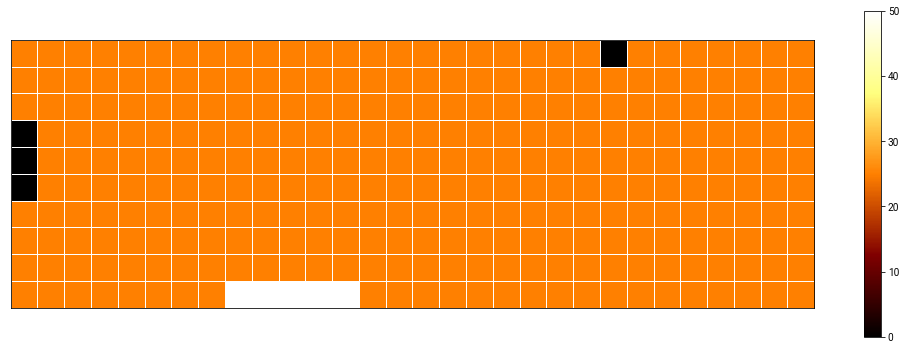

In [6]:
visualize_bar(bar);

This is exactly what we expected to see.

## Boundary conditions

There are a few different kinds of boundary conditions we could choose, which include

1.  Absorbing boundary conditions
2.  Reflecting boundary conditions
3.  Periodic boundary conditions

In this ongoing example, we will implement the **reflecting boundary conditions**.

In practice, implementing the absorbing or reflecting boundary conditions will require the use of **ghost cells**. You can also use ghost cells for periodic boundary conditions, but it isn't required. The following function sets up the ghost cells in `numpy`:

In [7]:
def boundary_condition(bar, condition="reflecting"):
    """Setup ghost cells for boundary condition.
    
    Parameters
    ----------
    bar : np.array
        A grid of temperatures
        
    condition : str, optional
        The boundary condition to use when creating ghost cells.
    """
    if condition == "reflecting":
        extended_bar = np.pad(array=bar, pad_width=(1, 1), mode='edge')

    else:
        raise ValueError(
            "{0} is not a valid boundary condition".format(condition))

    return extended_bar

After adding the ghost cells, we now have an extended bar. With this set up, we can now go through each site and look up the neighboring temperatures in the Moore neighborhood. We can do this efficiently using `numpy`:

In [8]:
def get_neighbor_temperatures(extended_bar,
                              ghost_width=(1, 1),
                              neighborhood="moore"):
    """Get the temperature of each site's neighbors in a single sweep.
    
    Paramters
    ---------
    extended_bar : np.array
        A grid of temperatures with ghost cells
        
    ghost_width : array-like
        A number pair that specifies how many rows and columns make up the
        ghost cell region
        
    neighborhood : str, optional
        Determines which cells will be counted as neighbors
        
    Returns
    -------
    bar_with_neighbors : np.array
        An array of temperatures for each site and its neighbors
    """
    m_extended, n_extended = extended_bar.shape
    m, n = (m_extended - ghost_width[0], n_extended - ghost_width[1])
    
    if neighborhood == "moore":
        bar_with_neighbors = np.array([
            np.roll(
                extended_bar, shift=(1, 1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_bar, shift=(0, 1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_bar, shift=(-1, 1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_bar, shift=(1, 0),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_bar, shift=(-1, 0),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_bar, shift=(1, -1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_bar, shift=(0, -1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_bar, shift=(-1, -1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n]])

    else:
        raise ValueError(
            "{0} is not a valid type of neighborhood".format(condition))

    return bar_with_neighbors

Now that we've collected all the temperatures of each cell's neighbors, we apply our diffusion formula,

$$
\begin{aligned}
T_{m,n}^{i+1}&=\left(1-8\tau\right)T_{m,n}^{i}+\tau\sum_{m',n'}^{\text{Moore}}T_{m',n'}^{i} \\
&=\left(1-8\tau\right)T_{m,n}^{i}+\tau\left(T_{m+1,n}+T_{m,n+1}+T_{m-1,n}+T_{m,n-1}+T_{m+1,n+1}+T_{m-1,n+1}+T_{m+1,n-1}+T_{m-1,n-1}\right)
\end{aligned}
$$

to each site in the grid. As usual, we can do this efficiently with `numpy` and vectorization. Note that we do not have any `for` loops below.

In [9]:
def diffusion(bar, bar_neighbors, diffusion_rate):
    """Update site temperatures using Newton's law of heating and cooling.
    
    Parameters
    ----------
    bar : np.array
        A grid of temperatures

    bar_neighbors : np.array
        An array of temperatures for each site and its neighbors

    diffusion_rate : float
        Paramter measuring ease of temperature flow from hot to cold sites.
        
    Returns
    -------
    bar_update : np.array
        A grid of temperatures after applying Newton's law of heating and
        cooling to all grid sites.
    """
    num_neighbors, m, n = bar_neighbors.shape
    
    bar_update = (
        (1 - num_neighbors * diffusion_rate) * bar +
        diffusion_rate * np.sum(a=bar_neighbors, axis=0))

    return bar_update

Now we sweep over all lattice points. In addition to the diffusion routine defined above, we reset the hot and cold points so that they stayed fixed at their respective temperatures. We also append the updated grid to the `simulation_history` list so that we can animate the diffusion simulation.

In [10]:
def sweep(bar, diffusion_rate, hot_sites, cold_sites, hot, cold, nstep,
          simulation_history):
    """Sweep over grid and update temperatures.
    
    Parameters
    ----------
    bar : np.array
        A grid of temperatures

    diffusion_rate : float
        Paramter measuring ease of temperature flow from hot to cold sites.

    hot_sites : list
        A list of coordinates inside the `bar` grid that have temperature
        `hot`

    cold_sites : list
        A list of coordinates inside the `bar` grid that have temperature
        `cold`

    hot : float
        The initial temperature of each coordinate in `hot_sites`

    cold : float
        The initial temperature of each coordinate in `cold_sites`

    simulation_history : list
        Time-step history for the simulation's run.
    """
    extended_bar = boundary_condition(bar) 
    bar_neighbors = get_neighbor_temperatures(extended_bar)
    bar_diffused = diffusion(bar, bar_neighbors, diffusion_rate)
    bar_full_update = apply_hot_cold(
        bar_diffused, hot_sites, cold_sites, hot, cold)
    bar[:, :] = bar_full_update
    simulation_history.append([nstep, bar_full_update])

## Simulation Program

Finally, we bring it all together into a function that runs the full simulation from start to finish. This is where we put our `for` loop over time.

In [11]:
def diffusion_simulation(number_time_steps, m, n, hot_sites, cold_sites, hot,
                         cold, ambient, diffusion_rate):
    """Run temperature diffusion simulation.
    
    Parameters
    ----------
    number_time_steps : int
        Sets the number of time steps over which to run a simulation.

    m : int
        Number of rows in the grid
        
    n : int
        Number of columns in the grid

    hot_sites : list
        List of sites inside the `bar` grid that have temperature `hot`

    cold_sites : list
        List of sites inside the `bar` grid that have temperature `cold`

    hot : float
        The initial temperature of the `hot_sites`

    cold : float
        The initial temperature of the `cold_sites`
        
    ambient : float
        The initial temperature for all other sites

    diffusion_rate : float
        Paramter measuring ease of temperature flow from hot to cold sites
    
    Returns
    -------
    simulation_history : list
        The temperature grid as a function of time during the temperature
        diffusion simulation
    """
    # Initialize bar according to parameters
    bar = init_bar(
        m=m, n=n, hot_sites=hot_sites, cold_sites=cold_sites, hot=hot,
        cold=cold, ambient=ambient)

    # Initialize record keeper for the simulation history
    simulation_history = [[0, bar.copy()]]

    # Run simulation for specified number of time steps
    for nstep in np.arange(number_time_steps):
        sweep(bar=bar, diffusion_rate=diffusion_rate, hot_sites=hot_sites,
              cold_sites=cold_sites, hot=hot, cold=cold, nstep=nstep,
              simulation_history=simulation_history)

    return simulation_history

## Display Simulation

Having successfully run our simulation, now we would like to see it in action! The code below is similar to the animation we created for the Random Walk in module 9.5. We advance each frame of the animation by incrementing the index on `simulation_history` by 1.

In [12]:
def diffusion_animation(simulation_history, cmap="afmhot", fig_width=12,
                        fig_height=4):
    """Animate the temperature diffusion simulation using Matplotlib.

    Parameters
    ----------
    simulation_history : list
        Time-step history for the simulation's run.
    
    cmap : str, optional
        Color scheme for the heatmap scale, see colormaps_ reference.
        
    fig_width : float, optional
        Figure width in inches
        
    fig_height : float, optional
        Figure height in inches
        
    Returns
    -------
    anim : matplotlib.animation.FuncAnimation
        Animated object for the simulation run.
        
    .. _colormaps: https://matplotlib.org/examples/color/colormaps_reference.html 
    """
    # grid dimensions
    m, n = simulation_history[0][1].shape

    # create matplotlib figure and subplot objects
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # imshow visualizes array as a two-dimensionl uniform grid
    im = ax.imshow(bar, cmap=cmap, interpolation="nearest")

    # show reference colorbar
    cbar = fig.colorbar(mappable=im, orientation="vertical")

    # find the starting and ending coordinates for heatmap for creating
    # grid lines
    xticks_start, xticks_end = ax.get_xlim();
    yticks_start, yticks_end = ax.get_ylim();

    # separate grid cells by white lines
    ax.xaxis.set_ticks(np.linspace(xticks_start, xticks_end, n + 1),
                       minor=False);
    ax.yaxis.set_ticks(np.linspace(yticks_start, yticks_end, m + 1),
                       minor=False);
    ax.axes.grid(True, linestyle="-", linewidth=1, color="white",
                 which="major");
    
    # we don't need ticks and tick labels because we have grid lines
    ax.tick_params(labelbottom = False, labelleft=False, bottom=False,
                   left=False);
    
    # Initialization function, clears out the data on the im object
    def init():
        im.set_array(np.array([[]]))
        return (im, )


    # Animation function. Input i is the frame number of the animation, and is
    # to be used for referencing how the data changes over time
    def animate(i):
        # Get the simulation history at time step i and set as the underlying
        # data for the im object
        bar_i = simulation_history[i][1]
        im.set_array(bar_i)

        return (im, )

    # Suppress static matplotlib window
    plt.close()
    
    # Use animation.FuncAnimation to put the animation together.
    # frames controls the number of frames in the movie.
    # interval controls the delay in milliseconds inbetween each frame
    # blit optimizes the animation size by only storing the changes between
    # frames instead of as a series of full plots
    anim = animation.FuncAnimation(fig=fig, func=animate,
                                   frames=len(simulation_history),
                                   init_func=init, interval=100, blit=True);

    return anim

## Example Run

Now that all the pieces are in place, let's run the simulation with the following initial parameters, which match the parameters suggested on page 429 of the textbook.

In [13]:
m, n = (10, 30)
hot, cold, ambient = (50, 0, 25)
hot_sites = np.array([278, 279, 280, 281, 282])
cold_sites = np.array([22, 90, 120, 150])
diffusion_rate = 0.1
number_time_steps = 50
simulation_history = diffusion_simulation(
    number_time_steps=number_time_steps, m=m, n=n, hot_sites=hot_sites,
    cold_sites=cold_sites, hot=hot, cold=cold, ambient=ambient,
    diffusion_rate=diffusion_rate)

We then build our animation:

In [14]:
anim = diffusion_animation(simulation_history)

And view it:

In [ ]:
HTML(anim.to_html5_video())

## Basic analysis of simulation outputs

In [16]:
middle_column_over_time = []
middle_row_over_time = []
check_correlation = []
for time_step in simulation_history:
    middle_column_over_time.append([time_step[0], time_step[1][:, 14]])
    middle_row_over_time.append([time_step[0], time_step[1][4, :]])
    check_correlation.append([time_step[1][7, 5], time_step[1][5, 9]])

In [17]:
middle_column_over_time[0][1]

array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25.])

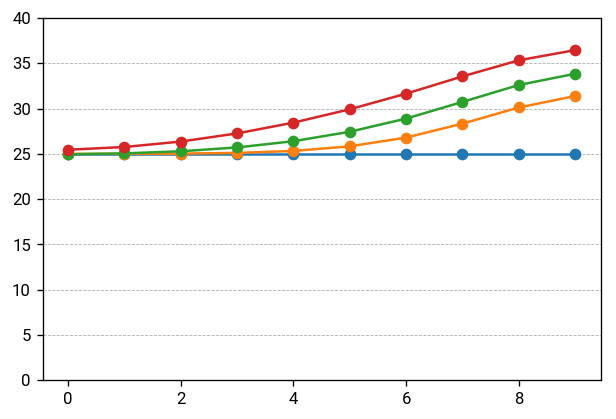

In [18]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

ax.plot(np.arange(10), middle_column_over_time[0][1], '-o');
ax.plot(np.arange(10), middle_column_over_time[10][1], '-o');
ax.plot(np.arange(10), middle_column_over_time[20][1], '-o');
ax.plot(np.arange(10), middle_column_over_time[50][1], '-o');

ax.set_ylim([0, 40]);

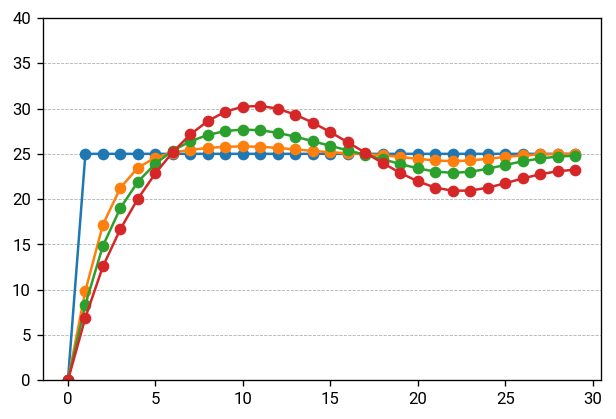

In [19]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

ax.plot(np.arange(30), middle_row_over_time[0][1], '-o');
ax.plot(np.arange(30), middle_row_over_time[10][1], '-o');
ax.plot(np.arange(30), middle_row_over_time[20][1], '-o');
ax.plot(np.arange(30), middle_row_over_time[50][1], '-o');

ax.set_ylim([0, 40]);

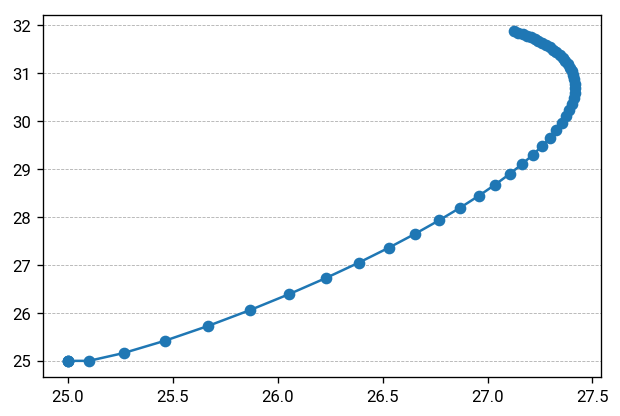

In [20]:
check_correlation = np.array(check_correlation)
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

ax.plot(check_correlation[:, 0], check_correlation[:, 1], '-o');

## Credits

*   Dr. Will Holmes, ["Heat Diffusion Example using Cellular Automaton" Jupyter notebook](https://github.com/Learning-Computational-Science/Cellular_Automaton/blob/master/CA_Heat_Diffusion.ipynb)